In [88]:
!pip install pycox torchtuples

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.2.2 -> 25.0.1
[notice] To update, run: /gnu/store/xsflhzksdnlwsigw9iicbg99qmh5hz82-python-3.10.7/bin/python3.10 -m pip install --upgrade pip


In [91]:
import os
import flexynesis
import flexynesis.utils as futils
import torch
import numpy as np
import seaborn as sns
import pandas as pd
import random
import lightning as pl
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from lifelines import KaplanMeierFitter
from sklearn.manifold import TSNE

In [2]:
if not os.path.exists("lgggbm_tcga_pub_processed"):
    !wget -O lgggbm_tcga_pub_processed.tgz "https://bimsbstatic.mdc-berlin.de/akalin/buyar/flexynesis-benchmark-datasets/lgggbm_tcga_pub_processed.tgz" && tar -xzvf lgggbm_tcga_pub_processed.tgz

--2025-03-14 22:41:51--  https://bimsbstatic.mdc-berlin.de/akalin/buyar/flexynesis-benchmark-datasets/lgggbm_tcga_pub_processed.tgz
Resolving bimsbstatic.mdc-berlin.de (bimsbstatic.mdc-berlin.de)... 141.80.181.47, 141.80.181.46
connected. to bimsbstatic.mdc-berlin.de (bimsbstatic.mdc-berlin.de)|141.80.181.47|:443... 
HTTP request sent, awaiting response... 200 OK
Length: 1817945 (1.7M) [application/octet-stream]
Saving to: ‘lgggbm_tcga_pub_processed.tgz’

lgggbm_tcga_pub_pro 100%[===================>]   1.73M  --.-KB/s    in 0.1s    

2025-03-14 22:41:52 (15.7 MB/s) - ‘lgggbm_tcga_pub_processed.tgz’ saved [1817945/1817945]

lgggbm_tcga_pub_processed/
lgggbm_tcga_pub_processed/train/
lgggbm_tcga_pub_processed/train/mut.csv
lgggbm_tcga_pub_processed/train/cna.csv
lgggbm_tcga_pub_processed/train/clin.csv
lgggbm_tcga_pub_processed/test/
lgggbm_tcga_pub_processed/test/mut.csv
lgggbm_tcga_pub_processed/test/cna.csv
lgggbm_tcga_pub_processed/test/clin.csv


## Importing Train and Test Datasets

We import train and test datasets including mutations and copy number alterations. We rank genes by Laplacian Scores and pick top 10% of the genes, while removing highly redundant genes with a correlation score threshold of 0.8 and a variance threshold of 50%. By setting `concatenate` to `False`, we will be doing an `intermediate` fusion of omic layers. 

In [3]:
data_importer = flexynesis.DataImporter(path ='lgggbm_tcga_pub_processed', 
                                        data_types = ['mut', 'cna'], log_transform=False, 
                                        concatenate=False, top_percentile=10, min_features=1000, correlation_threshold=0.8, 
                                       variance_threshold=0.5)
train_dataset, test_dataset = data_importer.import_data()


[INFO] ================= Importing Data =================
[INFO] Validating data folders...

[INFO] ----------------- Reading Data ----------------- 
[INFO] Importing lgggbm_tcga_pub_processed/train/cna.csv...
[INFO] Importing lgggbm_tcga_pub_processed/train/clin.csv...
[INFO] Importing lgggbm_tcga_pub_processed/train/mut.csv...

[INFO] ----------------- Reading Data ----------------- 
[INFO] Importing lgggbm_tcga_pub_processed/test/cna.csv...
[INFO] Importing lgggbm_tcga_pub_processed/test/clin.csv...
[INFO] Importing lgggbm_tcga_pub_processed/test/mut.csv...

[INFO] ----------------- Checking for problems with the input data ----------------- 
[INFO] Data structure is valid with no errors or warnings.

[INFO] ----------------- Processing Data (train) ----------------- 

[INFO] ----------------- Cleaning Up Data ----------------- 

[INFO] working on layer:  mut
[INFO] Number of NA values:  0
[INFO] DataFrame mut - Removed 5561 features.

[INFO] working on layer:  cna
[INFO] Number of

Filtering redundant features: 100%|██████████| 1000/1000 [00:00<00:00, 14356.78it/s]


[INFO] Implementing feature selection using laplacian score for layer: cna with  12371 features  and  556  samples 


OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detec


[INFO] ----------------- Processing Data (test) ----------------- 

[INFO] ----------------- Cleaning Up Data ----------------- 

[INFO] working on layer:  mut
[INFO] Number of NA values:  0
[INFO] DataFrame mut - Removed 5627 features.

[INFO] working on layer:  cna
[INFO] Number of NA values:  0
[INFO] DataFrame cna - Removed 12382 features.
[INFO] DataFrame mut - Removed 0 samples (0.00%).
[INFO] DataFrame cna - Removed 0 samples (0.00%).

[INFO] ----------------- Harmonizing Data Sets ----------------- 

[INFO] ----------------- Finished Harmonizing ----------------- 

[INFO] ----------------- Normalizing Data ----------------- 

[INFO] ----------------- Normalizing Data ----------------- 
[INFO] Training Data Stats:  {'feature_count in: mut': 323, 'feature_count in: cna': 1237, 'sample_count': 556}
[INFO] Test Data Stats:  {'feature_count in: mut': 323, 'feature_count in: cna': 1237, 'sample_count': 238}
[INFO] Merging Feature Logs...
[INFO] Data import successful.


## 1. Exploratory Data Analysis 

In [10]:
for data_type in train_dataset.keys():
    print(f"Data Type: {data_type}")
    print(f"  Train shape: {train_dataset[data_type].shape}")
    print(f"  Test shape: {test_dataset[data_type].shape}")
    print()

{'feature_count in: mut': 323, 'feature_count in: cna': 1237, 'sample_count': 556}


In [9]:
print(dir(train_dataset))

['__add__', '__annotations__', '__class__', '__class_getitem__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__orig_bases__', '__parameters__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_is_protocol', 'ann', 'dat', 'feature_ann', 'features', 'get_dataset_stats', 'get_feature_subset', 'label_mappings', 'samples', 'subset', 'variable_types']


In [11]:
print(f"Number of samples in train dataset: {len(train_dataset.samples)}")
print(f"Number of features in train dataset: {len(train_dataset.features)}")

print(f"Number of samples in test dataset: {len(test_dataset.samples)}")
print(f"Number of features in test dataset: {len(test_dataset.features)}")

Number of samples in train dataset: 556
Number of features in train dataset: 2
Number of samples in test dataset: 238
Number of features in test dataset: 2


## 1.2 Explore sample annotations 

In [15]:
print(train_dataset.ann.keys())
print(test_dataset.ann.keys())

dict_keys(['AGE', 'OS_MONTHS', 'OS_STATUS', 'KARNOFSKY_PERFORMANCE_SCORE', 'STUDY', 'BCR_STATUS', 'HISTOLOGICAL_DIAGNOSIS', 'SEX'])
dict_keys(['AGE', 'OS_MONTHS', 'OS_STATUS', 'KARNOFSKY_PERFORMANCE_SCORE', 'STUDY', 'BCR_STATUS', 'HISTOLOGICAL_DIAGNOSIS', 'SEX'])


In [16]:
train_ann_df = pd.DataFrame(train_dataset.ann)
test_ann_df = pd.DataFrame(test_dataset.ann)

print("Train Clinical Data Summary:\n", train_ann_df.describe(include='all'))
print("\nTest Clinical Data Summary:\n", test_ann_df.describe(include='all'))

Train Clinical Data Summary:
               AGE   OS_MONTHS   OS_STATUS  KARNOFSKY_PERFORMANCE_SCORE  \
count  521.000000  521.000000  520.000000                   330.000000   
mean    50.337812   19.090979    0.361538                    82.454545   
std     15.961645   24.083033    0.480909                    14.988528   
min     14.000000    0.000000    0.000000                    20.000000   
25%     37.000000    5.200000    0.000000                    80.000000   
50%     51.000000   11.600000    0.000000                    80.000000   
75%     63.000000   21.600000    1.000000                    90.000000   
max     88.000000  182.200000    1.000000                   100.000000   

            STUDY  BCR_STATUS  HISTOLOGICAL_DIAGNOSIS         SEX  
count  556.000000  556.000000              521.000000  521.000000  
mean     0.365108    0.183453                1.414587    0.598848  
std      0.481894    0.387386                1.081709    0.490603  
min      0.000000    0.000000  

In [18]:
train_ann_df = pd.DataFrame(train_dataset.ann)
test_ann_df = pd.DataFrame(test_dataset.ann)

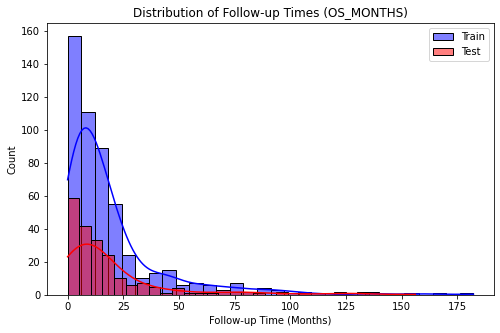

In [21]:
plt.figure(figsize=(8, 5))
sns.histplot(train_ann_df["OS_MONTHS"], bins=30, kde=True, color="blue", label="Train")
sns.histplot(test_ann_df["OS_MONTHS"], bins=30, kde=True, color="red", label="Test", alpha=0.5)

plt.xlabel("Follow-up Time (Months)")
plt.ylabel("Count")
plt.title("Distribution of Follow-up Times (OS_MONTHS)")
plt.legend()
plt.show()

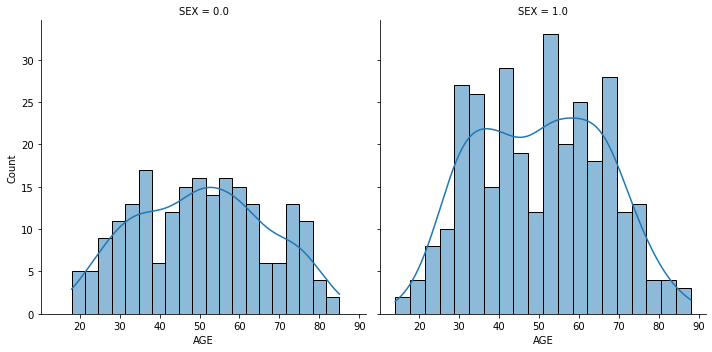

In [28]:
train_ann_df = pd.DataFrame(train_dataset.ann)
g = sns.FacetGrid(train_ann_df, col="SEX", height=5, aspect=1)
g.map(sns.histplot, "AGE", bins=20, kde=True)
plt.show()

In [30]:
futils.print_summary_stats(train_dataset)

Summary for variable: AGE
Numerical Variable Summary: Median = 51.0, Mean = 50.33781190019194
------
Summary for variable: OS_MONTHS
Numerical Variable Summary: Median = 11.6, Mean = 19.090978886756236
------
Summary for variable: OS_STATUS
Numerical Variable Summary: Median = 0.0, Mean = 0.36153846153846153
------
Summary for variable: KARNOFSKY_PERFORMANCE_SCORE
Numerical Variable Summary: Median = 80.0, Mean = 82.45454545454545
------
Summary for variable: STUDY
Categorical Variable Summary:
  Label: Brain Lower Grade Glioma, Count: 353
  Label: Glioblastoma multiforme, Count: 203
------
Summary for variable: BCR_STATUS
Categorical Variable Summary:
  Label: IGC, Count: 454
  Label: NCH, Count: 102
------
Summary for variable: HISTOLOGICAL_DIAGNOSIS
Categorical Variable Summary:
  Label: astrocytoma, Count: 115
  Label: glioblastoma, Count: 201
  Label: oligoastrocytoma, Count: 79
  Label: oligodendroglioma, Count: 126
  Label: nan, Count: 35
------
Summary for variable: SEX
Categor

In [33]:
top_10_study_numeric = train_dataset.ann['STUDY'][:10]
study_mapping = train_dataset.label_mappings['STUDY']

In [34]:
top_10_study_labels = [study_mapping[int(val.item())] for val in top_10_study_numeric]
print("Top 10 STUDY values (numerical encoding):", top_10_study_numeric)
print("Top 10 STUDY values (mapped labels):", top_10_study_labels)

Top 10 STUDY values (numerical encoding): tensor([0., 0., 0., 0., 0., 0., 1., 0., 1., 0.], dtype=torch.float64)
Top 10 STUDY values (mapped labels): ['Brain Lower Grade Glioma', 'Brain Lower Grade Glioma', 'Brain Lower Grade Glioma', 'Brain Lower Grade Glioma', 'Brain Lower Grade Glioma', 'Brain Lower Grade Glioma', 'Glioblastoma multiforme', 'Brain Lower Grade Glioma', 'Glioblastoma multiforme', 'Brain Lower Grade Glioma']


In [35]:
df = pd.DataFrame(train_dataset.dat['cna'], 
                  index=train_dataset.samples, 
                  columns=train_dataset.features['cna'])
df.head()

,SLC30A8,ZNF273,OR9A1P,AGL,KCNA5,MIR603,SNTB1,MRPL13,MTBP,SNORA72|ENSG00000252158.1,...,CAV1,FZD1,BCAP29,MNX1,ADAM22,LRP8,NOM1,RN7SL290P,CEP41,snoU13|ENSG00000239044.1
TCGA-DB-A4XC,-0.225196,-0.695324,-0.814911,0.386623,1.739968,0.600314,-0.233638,-0.233480,-0.233480,-0.236227,...,-0.818976,-0.766291,-0.819022,-0.796134,-0.745263,0.373331,-0.796317,0.382763,-0.837219,-0.837219
TCGA-DU-A5TW,1.924100,2.696018,2.981052,0.280691,-0.223039,0.593586,1.950029,1.950144,1.950144,1.936019,...,3.009691,2.912962,3.041708,3.072903,2.650560,0.297255,3.072591,0.305912,2.928016,2.928016
TCGA-DU-6405,-0.227827,0.706178,0.696675,0.381190,-0.207080,-1.155580,-0.236311,-0.236152,-0.236152,-0.238886,...,0.692996,0.715630,0.705612,0.699027,0.658092,0.397785,0.698794,0.407465,0.649704,0.649704
TCGA-CS-6290,0.624526,-0.743652,-0.867035,0.378474,-0.284217,0.506128,0.629672,0.629813,0.629813,0.622568,...,-0.871113,-0.817392,-0.871596,-0.847691,-0.793655,0.395068,-0.847873,0.404721,-0.888492,-0.888492
TCGA-DU-6397,-0.264657,-0.745753,-0.828509,-1.653239,-0.180481,0.566676,-0.273730,-0.273571,-0.273571,-0.105946,...,-0.873380,-0.819614,-0.873882,-0.809584,-0.795758,-1.637264,-0.809767,-1.648293,-0.850594,-0.850594


In [38]:
histological_numeric = train_dataset.ann['HISTOLOGICAL_DIAGNOSIS']
histological_numeric = np.nan_to_num(histological_numeric, nan=-1)  
histological_labels = [
    train_dataset.label_mappings['HISTOLOGICAL_DIAGNOSIS'].get(int(val.item()), "Unknown") 
    for val in histological_numeric
]

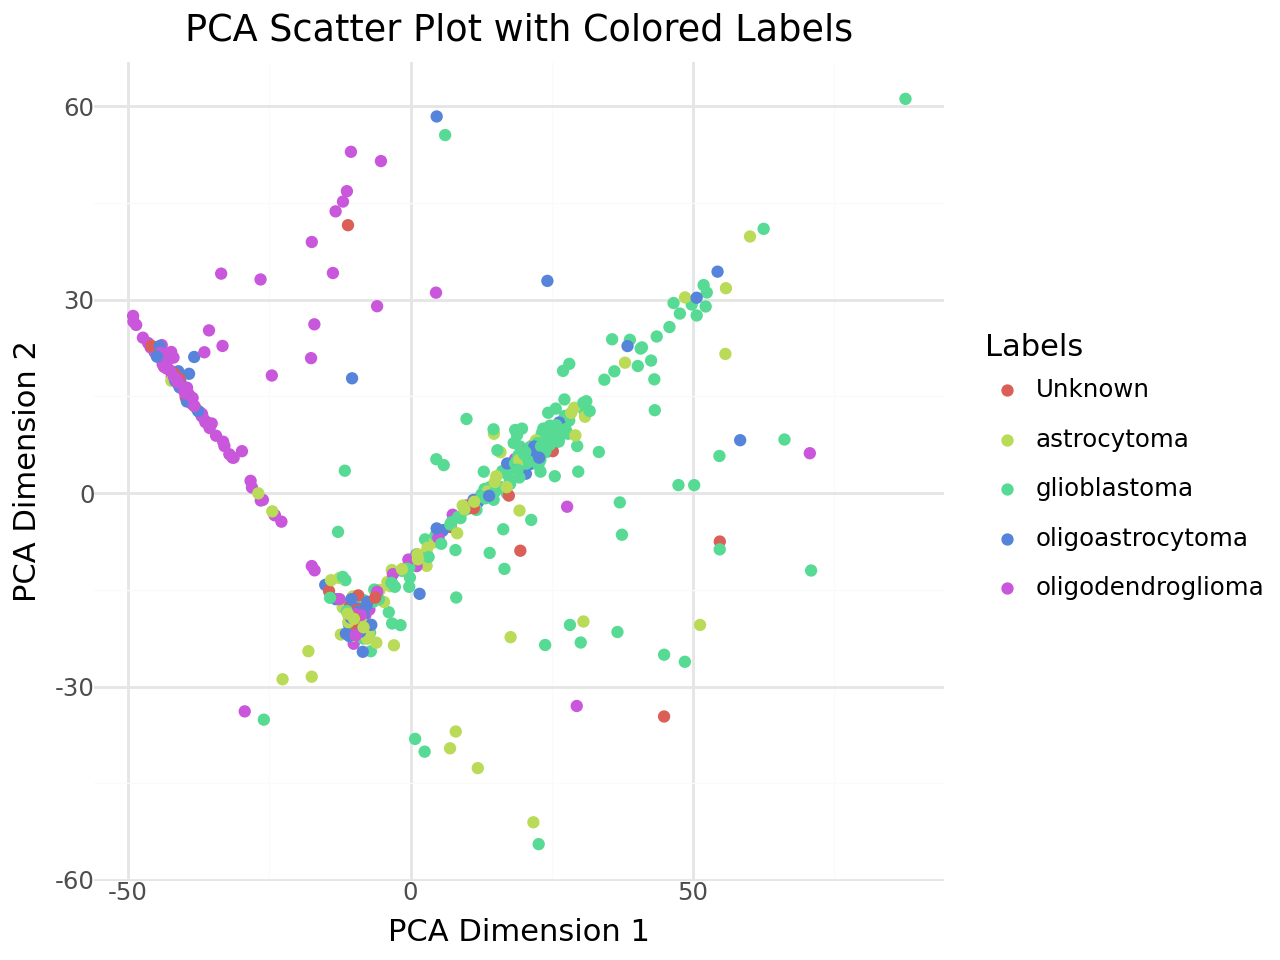

In [ ]:
futils.plot_dim_reduced(
    df, 
    labels=histological_labels, 
    method='PCA'  
)

## t-SNE for dimensionality reduction

In [79]:
E = model.transform(test_dataset)

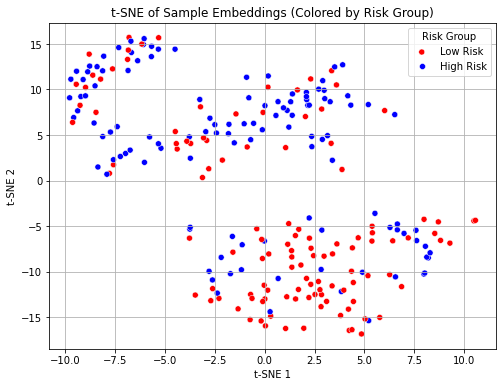

In [ ]:
E_tsne = TSNE(n_components=2, random_state=42).fit_transform(E)

plt.figure(figsize=(8,6))
sns.scatterplot(x=E_tsne[:,0], y=E_tsne[:,1], hue=groups, palette=['blue', 'red'])
plt.title("t-SNE of Sample Embeddings (Colored by Risk Group)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(title="Risk Group", labels=["Low Risk", "High Risk"])
plt.grid()
plt.show()

## 2. Training a single model using manually set hyperparameters 

In [ ]:
train_indices = random.sample(range(0, len(train_dataset)), int(len(train_dataset) * 0.8))
val_indices = list(set(range(len(train_dataset))) - set(train_indices))
train_subset = train_dataset.subset(train_indices)
val_subset = train_dataset.subset(val_indices)

from torch.utils.data import DataLoader
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True) 
val_loader = DataLoader(val_subset, batch_size=32, shuffle = False) 

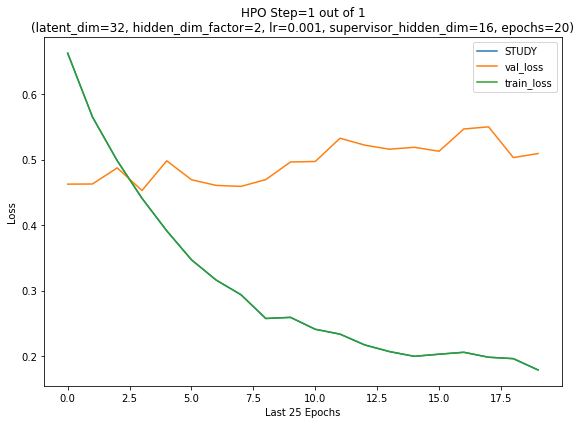

`Trainer.fit` stopped: `max_epochs=20` reached.


In [ ]:
myparams = {'latent_dim': 32, 'hidden_dim_factor': 2, 'lr': 0.001, 'supervisor_hidden_dim': 16, 'epochs': 20}
model = flexynesis.DirectPred(config = myparams, dataset = train_dataset, target_variables=['STUDY'])   
trainer = pl.Trainer(max_epochs=myparams['epochs'], default_root_dir="./", logger=False, enable_checkpointing=False, 
                     callbacks=[flexynesis.LiveLossPlot(myparams, 1, 1)])
trainer.fit(model, train_loader, val_loader)

While we can observe how well the model training went based on the "loss" values, we can also evaluate the model performance on test dataset 

In [6]:
flexynesis.evaluate_wrapper("DirectPred", model.predict(test_dataset), test_dataset)

,method,var,variable_type,metric,value
0,DirectPred,STUDY,categorical,balanced_acc,0.753595
1,DirectPred,STUDY,categorical,f1_score,0.763317
2,DirectPred,STUDY,categorical,kappa,0.493011
3,DirectPred,STUDY,categorical,average_auroc,0.849981
4,DirectPred,STUDY,categorical,average_aupr,0.723994


In [43]:
train_indices = random.sample(range(len(train_dataset)), int(len(train_dataset) * 0.8))
val_indices = list(set(range(len(train_dataset))) - set(train_indices))

In [44]:
train_subset = train_dataset.subset(train_indices)
val_subset = train_dataset.subset(val_indices)

In [45]:
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

In [46]:
hyperparameter_combinations = [
    {'latent_dim': 16, 'hidden_dim_factor': 1, 'lr': 0.005, 'supervisor_hidden_dim': 8, 'epochs': 15},
    {'latent_dim': 32, 'hidden_dim_factor': 2, 'lr': 0.001, 'supervisor_hidden_dim': 16, 'epochs': 20},  # Original setup
    {'latent_dim': 64, 'hidden_dim_factor': 3, 'lr': 0.0005, 'supervisor_hidden_dim': 32, 'epochs': 25},
    {'latent_dim': 128, 'hidden_dim_factor': 4, 'lr': 0.0001, 'supervisor_hidden_dim': 64, 'epochs': 30},
    {'latent_dim': 8, 'hidden_dim_factor': 1, 'lr': 0.01, 'supervisor_hidden_dim': 4, 'epochs': 10},
]

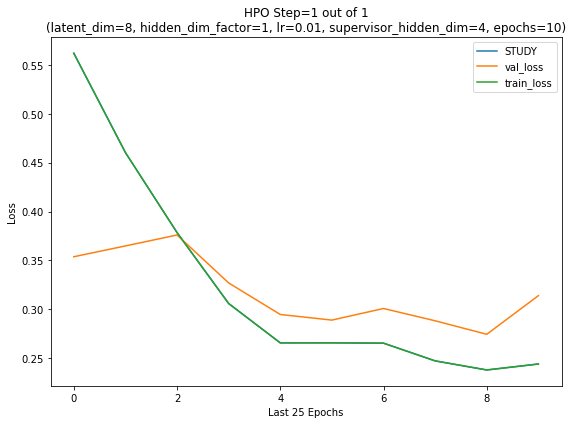

`Trainer.fit` stopped: `max_epochs=10` reached.


 Model 5 Evaluation Results:        method    var variable_type         metric     value
0  DirectPred  STUDY   categorical   balanced_acc  0.726144
1  DirectPred  STUDY   categorical       f1_score  0.751078
2  DirectPred  STUDY   categorical          kappa  0.455863
3  DirectPred  STUDY   categorical  average_auroc  0.806997
4  DirectPred  STUDY   categorical   average_aupr  0.699816


In [47]:
for idx, myparams in enumerate(hyperparameter_combinations):
    print(f"\n🔹 Training Model {idx+1} with Hyperparameters: {myparams}")

    model = flexynesis.DirectPred(config=myparams, dataset=train_dataset, target_variables=['STUDY'])

    trainer = pl.Trainer(
        max_epochs=myparams['epochs'], 
        default_root_dir="./", 
        logger=False, 
        enable_checkpointing=False,
        callbacks=[flexynesis.LiveLossPlot(myparams, 1, 1)]
    )

    trainer.fit(model, train_loader, val_loader)

    results = flexynesis.evaluate_wrapper("DirectPred", model.predict(test_dataset), test_dataset)
    print(f" Model {idx+1} Evaluation Results: {results}")

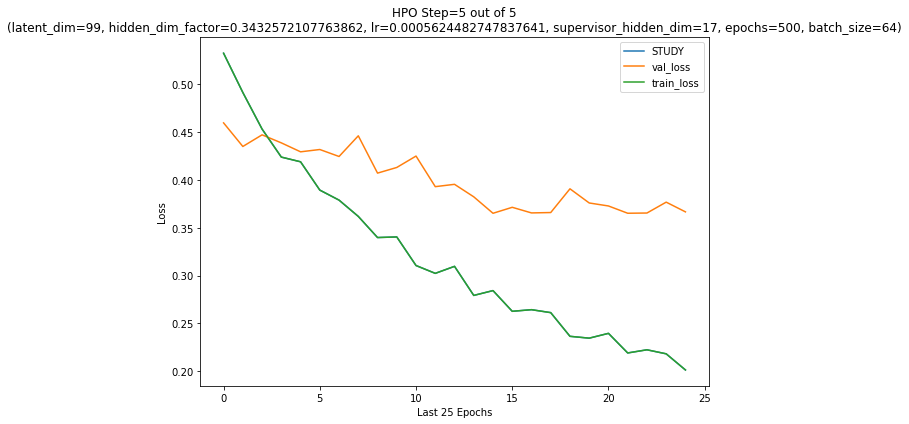

Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           STUDY           │    0.3666139543056488     │
│         val_loss          │    0.3666139543056488     │
└───────────────────────────┴───────────────────────────┘

Tuning Progress: 100%|██████████| 5/5 [00:39<00:00,  7.91s/it, Iteration=5, Best Loss=0.325]

[INFO] current best val loss: 0.3249063789844513; best params: {'latent_dim': 126, 'hidden_dim_factor': 0.27078553675835804, 'lr': 0.00021729140705127123, 'supervisor_hidden_dim': 16, 'epochs': 500, 'batch_size': 32} since 1 hpo iterations


In [ ]:
tuner = flexynesis.HyperparameterTuning(train_dataset, 
                                        model_class = flexynesis.DirectPred, 
                                        config_name = "DirectPred",
                                        target_variables = ['STUDY'], 
                                        n_iter=5, 
                                        plot_losses=True, 
                                        early_stop_patience=10)
model, best_params = tuner.perform_tuning()

In [ ]:
best_params

{'latent_dim': 126,
 'hidden_dim_factor': 0.27078553675835804,
 'lr': 0.00021729140705127123,
 'supervisor_hidden_dim': 16,
 'epochs': 35,
 'batch_size': 32}

In [50]:
flexynesis.evaluate_wrapper(method = 'DirectPred', y_pred_dict=model.predict(test_dataset), dataset = test_dataset)                            

,method,var,variable_type,metric,value
0,DirectPred,STUDY,categorical,balanced_acc,0.775163
1,DirectPred,STUDY,categorical,f1_score,0.769248
2,DirectPred,STUDY,categorical,kappa,0.517835
3,DirectPred,STUDY,categorical,average_auroc,0.849596
4,DirectPred,STUDY,categorical,average_aupr,0.727040


Let's extract the sample embeddings and make a PCA plot and color by the target variable 

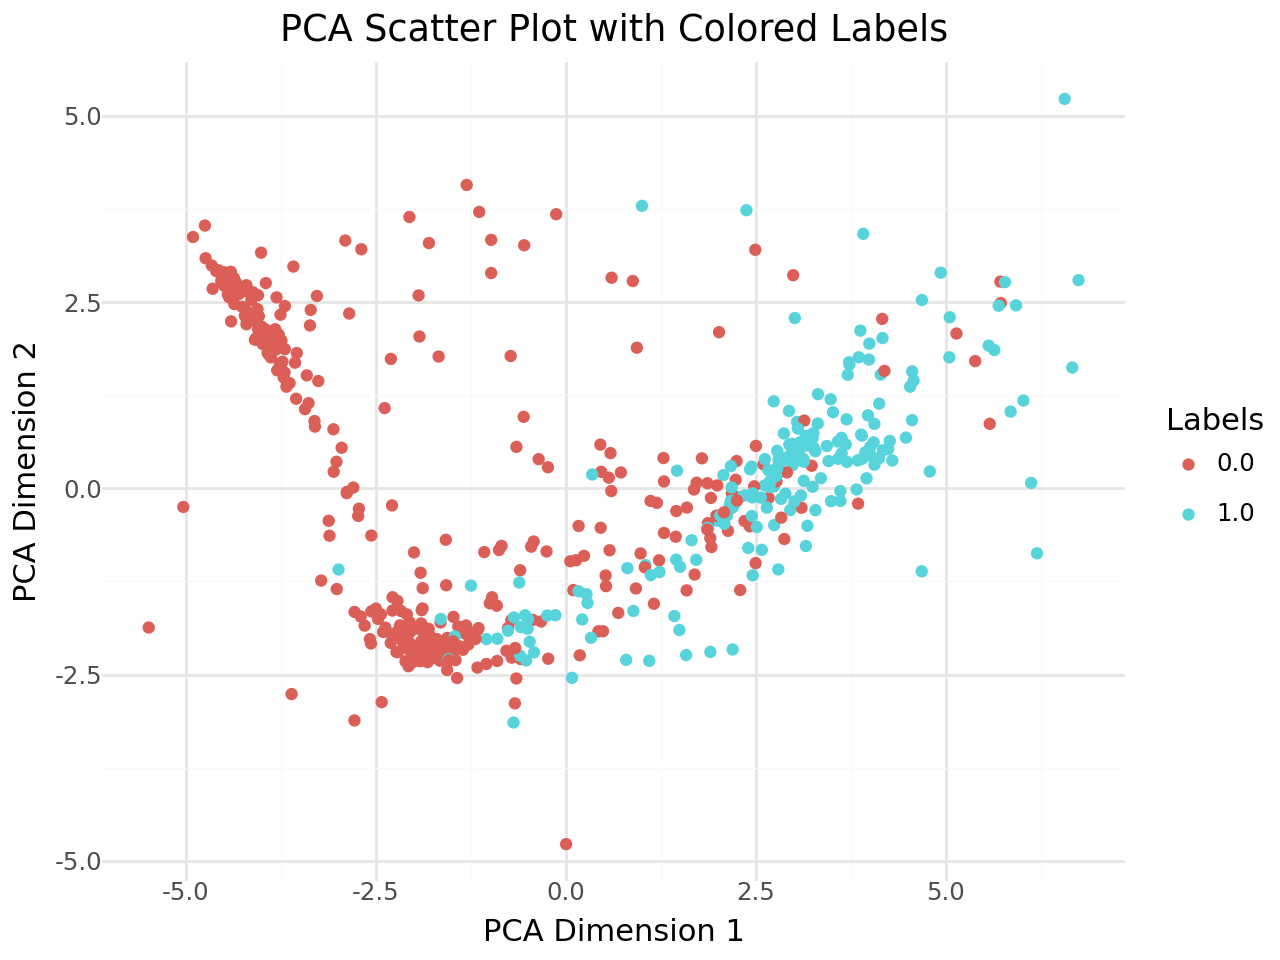

In [51]:
train_embeddings = model.transform(train_dataset)
flexynesis.plot_dim_reduced(train_embeddings, train_dataset.ann['STUDY'])

Repeat the same for the test dataset: extract sample embeddings for test dataset samples and make a PCA plot, colored by "STUDY" variable 

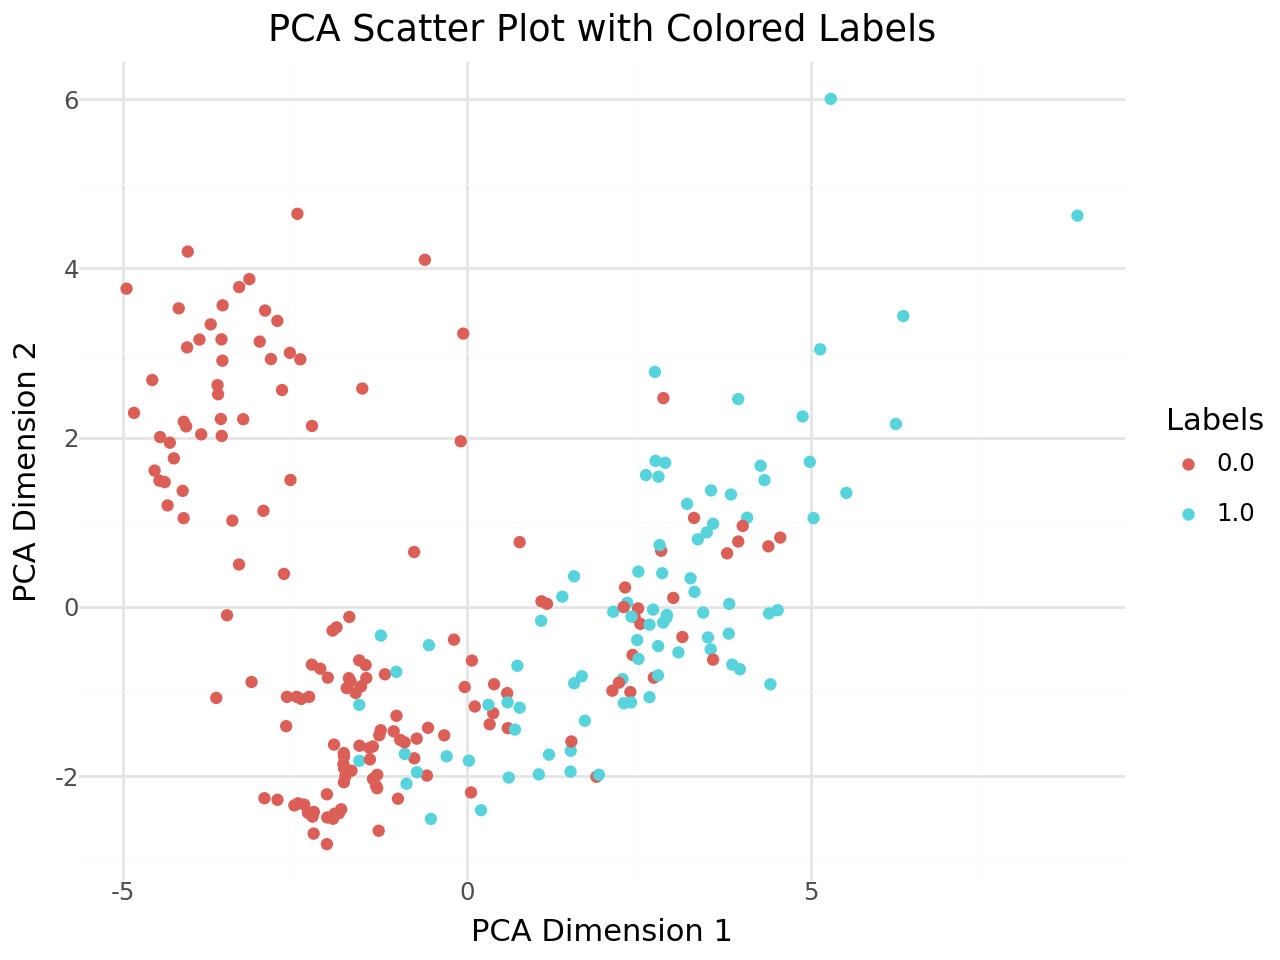

In [52]:
test_embeddings = model.transform(test_dataset)
flexynesis.plot_dim_reduced(test_embeddings, test_dataset.ann['STUDY'])

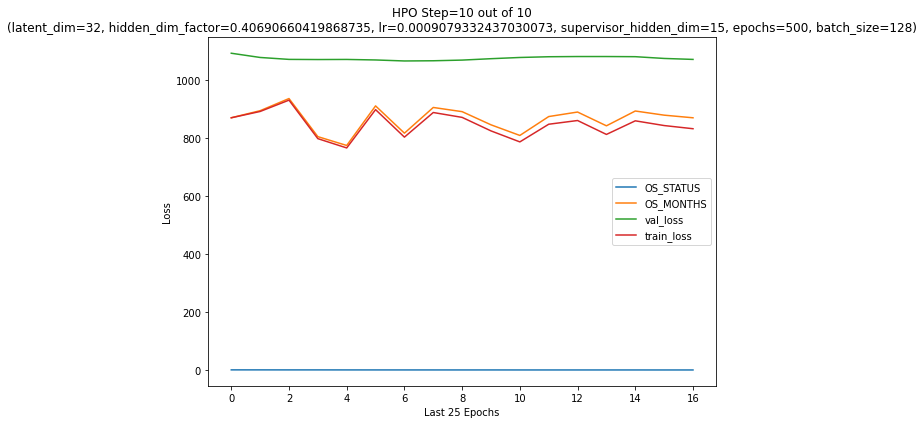

Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         OS_MONTHS         │    1072.5535888671875     │
│         OS_STATUS         │    0.21777081489562988    │
│         val_loss          │    1072.7713623046875     │
└───────────────────────────┴───────────────────────────┘

Tuning Progress: 100%|██████████| 10/10 [01:55<00:00, 11.60s/it, Iteration=10, Best Loss=428]

[INFO] current best val loss: 428.1090087890625; best params: {'latent_dim': 79, 'hidden_dim_factor': 0.28765429982540514, 'lr': 0.003056810846797574, 'supervisor_hidden_dim': 20, 'epochs': 500, 'batch_size': 128} since 9 hpo iterations
Best Hyperparameters Found: {'latent_dim': 79, 'hidden_dim_factor': 0.28765429982540514, 'lr': 0.003056810846797574, 'supervisor_hidden_dim': 20, 'epochs': 85, 'batch_size': 128}


In [54]:
model, best_params = tuner.perform_tuning()
print("Best Hyperparameters Found:", best_params)

In [55]:
y_pred_dict = model.predict(test_dataset)

evaluation_results = flexynesis.evaluate_wrapper(
    method='DirectPred', 
    y_pred_dict=y_pred_dict, 
    dataset=test_dataset
)
print("Model Evaluation Results:", evaluation_results)

Model Evaluation Results:        method        var variable_type        metric       value
0  DirectPred  OS_STATUS     numerical           mse    0.214209
1  DirectPred  OS_STATUS     numerical            r2    0.086150
2  DirectPred  OS_STATUS     numerical  pearson_corr    0.293513
3  DirectPred  OS_MONTHS     numerical           mse  820.228325
4  DirectPred  OS_MONTHS     numerical            r2    0.001543
5  DirectPred  OS_MONTHS     numerical  pearson_corr    0.039285


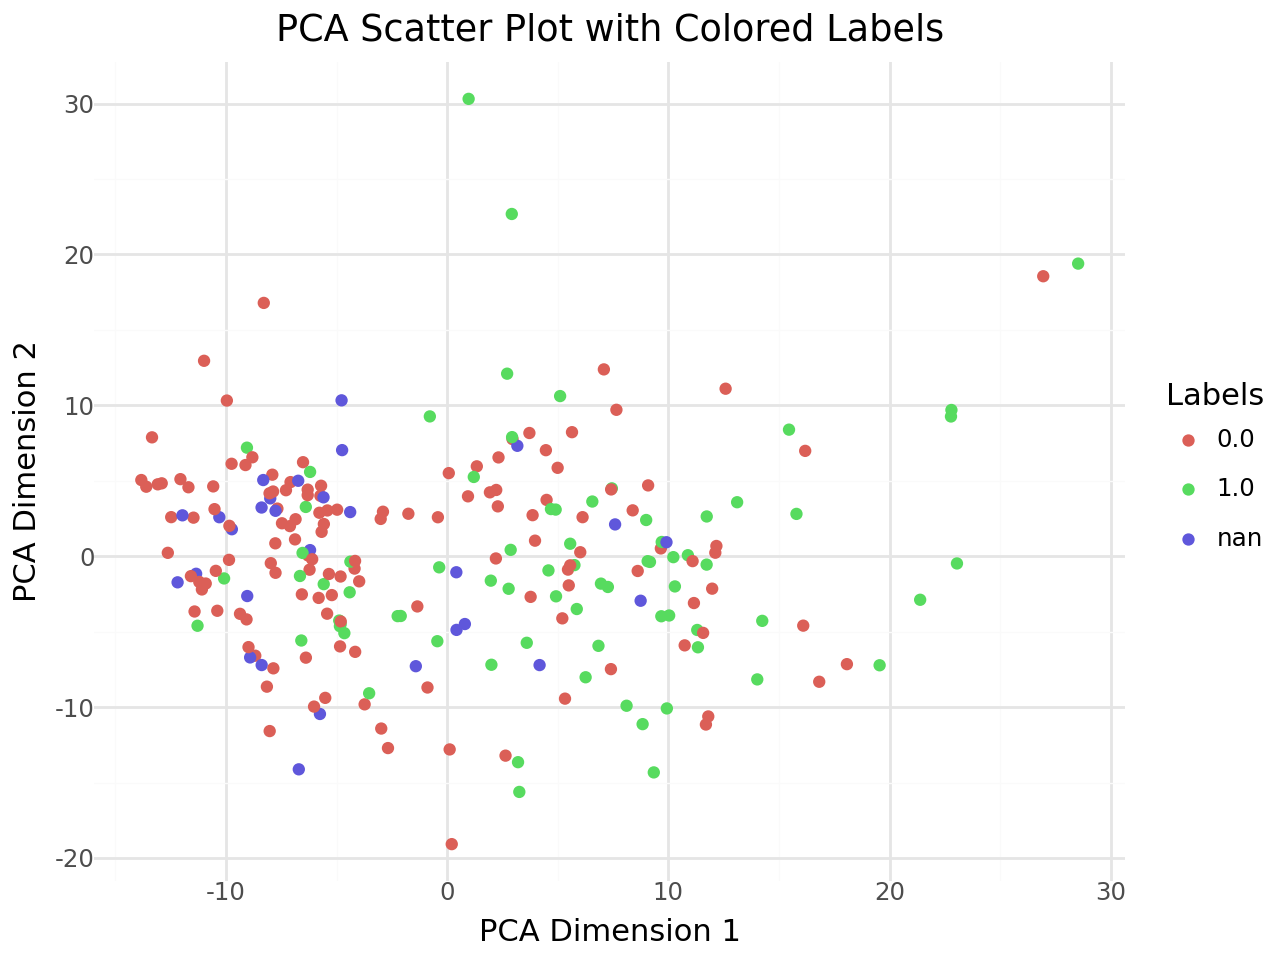

In [56]:
train_embeddings = model.transform(train_dataset)
test_embeddings = model.transform(test_dataset)

flexynesis.plot_dim_reduced(train_embeddings, train_dataset.ann['OS_STATUS'], method='PCA')
flexynesis.plot_dim_reduced(test_embeddings, test_dataset.ann['OS_STATUS'], method='PCA')

## 3.2 Survival-risk subtypes 

In [57]:
outputs = model.predict(test_dataset)['OS_STATUS'].flatten() 
risk_scores = np.exp(outputs)
quantiles = np.quantile(risk_scores, [0.5])
groups = np.digitize(risk_scores, quantiles)

In [58]:
E = model.transform(test_dataset)

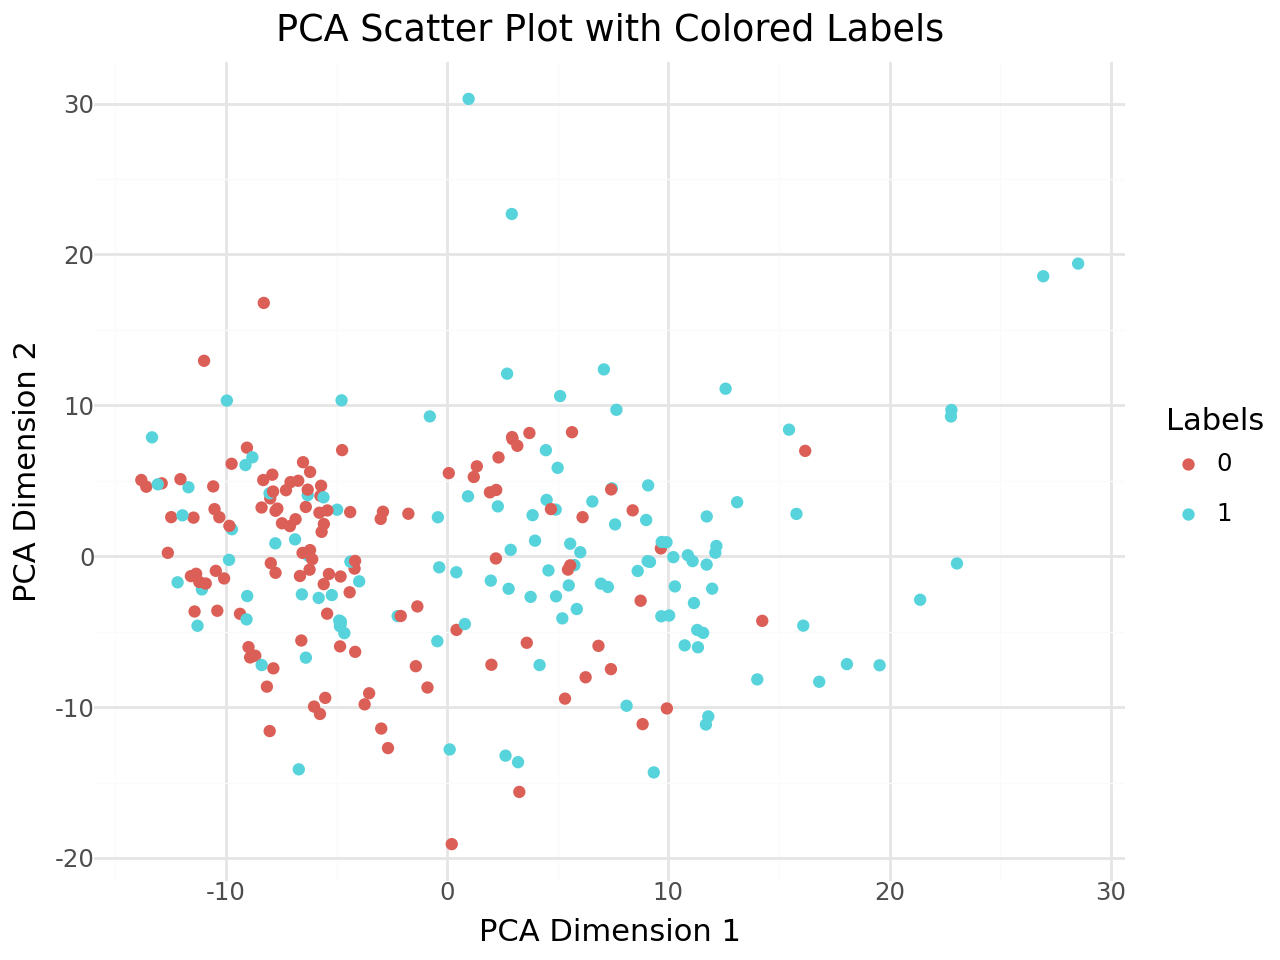

In [59]:
flexynesis.plot_dim_reduced(E, groups)

Let's also see the Kaplan Meier Curves of the risk subtypes

In [ ]:
durations = test_dataset.ann['OS_MONTHS']
events = test_dataset.ann['OS_STATUS']
valid_indices = ~torch.isnan(durations) & ~torch.isnan(events)

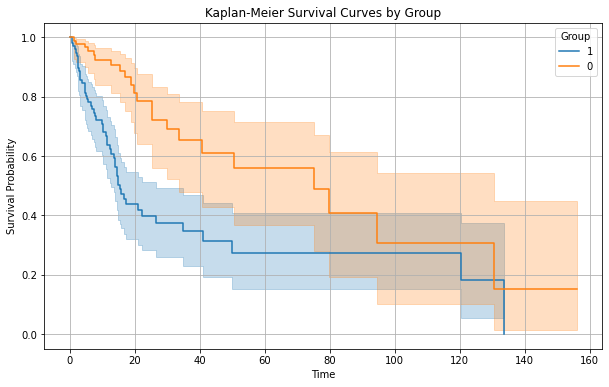

In [61]:
flexynesis.plot_kaplan_meier_curves(durations[valid_indices], events[valid_indices], groups[valid_indices]) 

### Finding survival-associated markers 

We can also compute feature importance scores for prediction of overall survival. 

In [62]:
model.compute_feature_importance(train_dataset, 'OS_STATUS')

In [63]:
flexynesis.get_important_features(model, var = 'OS_STATUS', top=10)

,target_variable,target_class,target_class_label,layer,name,importance
0,OS_STATUS,0,,mut,IDH1,0.069255
1,OS_STATUS,0,,mut,ATRX,0.030656
2,OS_STATUS,0,,mut,EGFR,0.016097
3,OS_STATUS,0,,mut,NF1,0.010594
4,OS_STATUS,0,,mut,MUC16,0.009340
5,OS_STATUS,0,,mut,CIC,0.007919
6,OS_STATUS,0,,mut,TP53,0.007540
7,OS_STATUS,0,,mut,IDH2,0.007185
8,OS_STATUS,0,,mut,PIK3CA,0.006156
9,OS_STATUS,0,,mut,SVIL,0.003547


### Comparing top markers with clinical covariates 

Let's build a linear Cox-PH model including the top 5 markers and other clinical variables such as histological diagnosis, disease type (STUDY), age, and sex. 

In [ ]:
vars = ['AGE', 'SEX', 'HISTOLOGICAL_DIAGNOSIS', 'STUDY', 'OS_MONTHS', 'OS_STATUS']
df_clin = pd.concat(
    [pd.DataFrame({x: train_dataset.ann[x] for x in vars}, index=train_dataset.samples),
     pd.DataFrame({x: test_dataset.ann[x] for x in vars}, index=test_dataset.samples)], 
    axis = 0)
imp = flexynesis.get_important_features(model, var = 'OS_STATUS', top=5) 
df_imp = pd.concat([train_dataset.get_feature_subset(imp), test_dataset.get_feature_subset(imp)], axis=0)  

df = pd.concat([df_imp, df_clin], axis = 1)
df = df[df['OS_STATUS'].notna()]
df

,mut_IDH1,mut_ATRX,mut_EGFR,mut_NF1,mut_MUC16,AGE,SEX,HISTOLOGICAL_DIAGNOSIS,STUDY,OS_MONTHS,OS_STATUS
TCGA-DB-A4XC,0.982173,1.707482,-0.331331,-0.267004,-0.363845,26.0,1.0,2.0,0.0,27.6,0.0
TCGA-DU-A5TW,0.982173,1.707482,-0.331331,-0.267004,2.748426,33.0,0.0,0.0,0.0,5.7,0.0
TCGA-DU-6405,-1.018150,-0.585658,-0.331331,-0.267004,-0.363845,51.0,0.0,0.0,0.0,19.9,1.0
TCGA-CS-6290,0.982173,-0.585658,-0.331331,-0.267004,-0.363845,31.0,1.0,0.0,0.0,17.9,0.0
TCGA-DU-6397,0.982173,-0.585658,-0.331331,-0.267004,-0.363845,45.0,1.0,3.0,0.0,46.0,1.0
TCGA-HW-8319,0.982173,1.707482,-0.331331,-0.267004,-0.363845,34.0,0.0,0.0,0.0,21.7,0.0
TCGA-76-4926,-1.018150,-0.585658,-0.331331,-0.267004,-0.363845,68.0,1.0,1.0,1.0,4.5,1.0
TCGA-P5-A72X,0.982173,-0.585658,-0.331331,-0.267004,-0.363845,21.0,1.0,0.0,0.0,0.3,0.0
TCGA-81-5910,-1.018150,-0.585658,3.018127,-0.267004,-0.363845,64.0,1.0,1.0,1.0,1.6,1.0
TCGA-06-5414,-1.018150,-0.585658,-0.331331,-0.267004,-0.363845,61.0,1.0,1.0,1.0,9.0,0.0


In [65]:
coxm = flexynesis.build_cox_model(df, 'OS_MONTHS', 'OS_STATUS')

No low variance features were removed based on event conditioning.


/gnu/store/88qdfdp9h0003w4wp1rv46khc3dpp8j6-profile/lib/python3.10/site-packages/flexynesis/utils.py:764: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


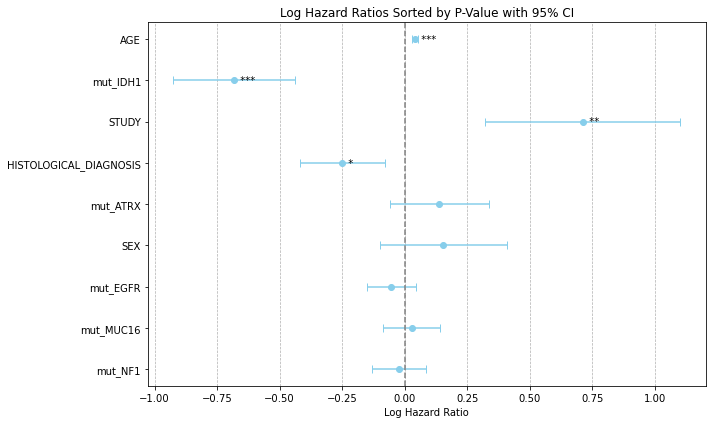

In [66]:
flexynesis.plot_hazard_ratios(coxm)

## Heatmap of Top 10 Predictive Genes (Mutation/CNA)

<function matplotlib.pyplot.show(close=None, block=None)>

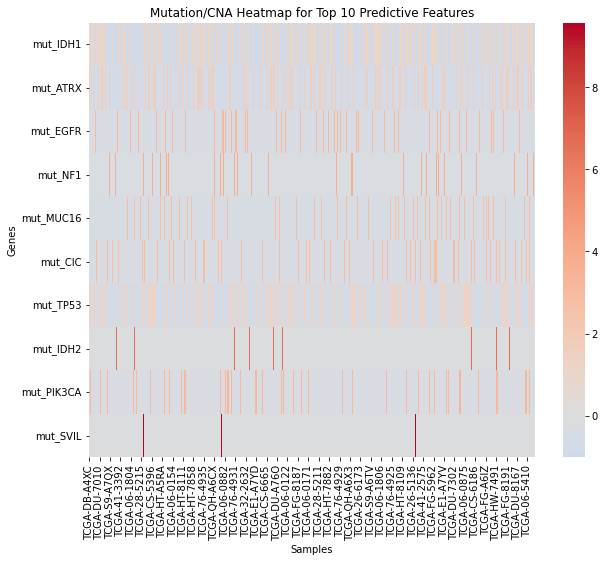

In [92]:
top_markers = flexynesis.get_important_features(model, var='OS_STATUS', top=10)
mut_data = train_dataset.get_feature_subset(top_markers)

plt.figure(figsize=(10,8))
sns.heatmap(mut_data.T, cmap="coolwarm", center=0)
plt.title("Mutation/CNA Heatmap for Top 10 Predictive Features")
plt.xlabel("Samples")
plt.ylabel("Genes")
plt.show

## The top 10 markers are:
- IDH1, ATRX, EGFR, NF1, MUC16, CIC, TP53, IDH2, PIK3CA, and SVIL